In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from Color import *

# Matplotlib font configuration
from MatplotlibFonts import *

# Change the font size
rcParams.update({"font.size": 15})

In [3]:
RESULT_DIR='../benchmarks/results'

In [4]:
# Benchmarks in order
Benchmarks = [
    'coremark',
    'sha',
    'crc',
    'aes',
    'dijkstra',
    'picojpeg'
]

# Configurations in order
Configurations = [
    'opt-ratchet',
    'opt-baseline',
    'opt-reducedpop',
    'opt-writebuf',
    'opt-loop',
    'opt-all',
    'opt-all-expander'
]
from BenchmarkConfiguration import *

In [5]:
# Load the benchmarks
def load_benchmark(bench):
    file = RESULT_DIR + '/raw/' + bench + '-results-table-raw.csv'
    return pd.read_csv(file).set_index('Configuration')

df = {}
for bench in Benchmarks:
    df[bench] = load_benchmark(bench)

In [6]:
# Order per group: Ratchet, Ratchet+Noelle, Write Buffering, Loop Clustering, Opt-all
group_size = len(Configurations)
group_count = len(Benchmarks)
print('Group count:', group_count)
print('Group size:', group_size)

Group count: 6
Group size: 7


In [7]:
#df['sha'] = df['sha'].reindex(ConfigurationNameMap)
df['sha']

,Cycles,Checkpoints,IR-checkpoints,Call-checkpoints,Pop-checkpoints,Spill-checkpoints,ELF-size,Execution,Execution-baseline,Overhead-baseline-%,Overhead-ratchet-%
Configuration,,,,,,,,,,,
uninstrumented,14341827,0,0,0,9947,0,12568,1.000000,0.656927,-100.00,-100.00
opt-ratchet,51115435,599751,589621,138,9986,5,16736,3.564081,2.341341,390.98,0.00
opt-baseline,21831688,131991,121861,138,9986,5,16512,1.522239,1.000000,0.00,-79.63
opt-writebuf,21787919,131991,121861,138,9986,5,16584,1.519187,0.997995,-0.58,-79.75
opt-loop,19122806,78467,53643,9921,10025,4877,16760,1.333359,0.875920,-36.17,-87.00
opt-all,18448499,68621,53643,5049,5051,4877,16784,1.286342,0.845033,-45.17,-88.83
opt-reducedpop,21493564,127017,121861,138,5012,5,16488,1.498663,0.984512,-4.51,-80.55
loop-unroll-15,18694042,68722,53642,5049,10025,5,16952,1.303463,0.856280,-41.89,-88.16
loop-unroll-4,19229946,88212,63388,9921,10025,4877,16584,1.340830,0.880827,-34.74,-86.71


In [8]:
dfa = pd.DataFrame()
for bench in Benchmarks:
    dfa[BenchmarkNameMap[bench]] = df[bench].reindex(ConfigurationNameMap)['Execution']
    
dfa.rename(index=ConfigurationNameMap, inplace=True)
dfa

,CoreMark,SHA,CRC,Tiny AES,Dijkstra,picojpeg
Configuration,,,,,,
Ratchet,3.396362,3.564081,3.744782,4.509444,1.072804,4.981554
R-PDG,3.236080,1.522239,3.744782,3.056914,1.026569,4.879361
Epilog Optimizer,3.170887,1.498663,2.841596,2.914701,1.021676,4.010509
Write Clusterer,3.206988,1.519187,3.748431,2.810931,1.025175,4.083024
Loop Write Clusterer,2.656285,1.333359,3.744685,2.274613,1.025710,4.685744
\textbf{WARio} (complete),2.480739,1.286342,2.841985,1.838695,1.046638,3.656676
"\textbf{WARio}\,+\,Expander",1.975509,1.304879,2.841985,1.895968,1.046638,3.559241


In [9]:
mean_ratchet = dfa.T[ConfigurationNameMap['opt-ratchet']].mean()
mean_baseline = dfa.T[ConfigurationNameMap['opt-baseline']].mean()
mean_opt_all = dfa.T[ConfigurationNameMap['opt-all-expander']].mean()

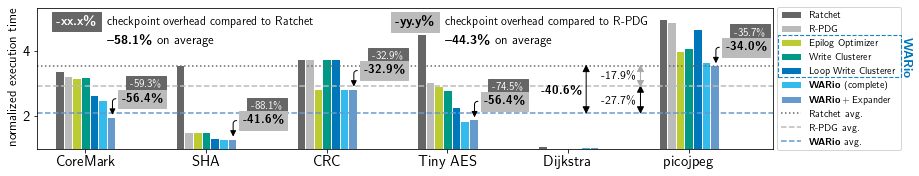

In [10]:
from statistics import mean

color_list = [ConfigurationColorMap[c] for c in Configurations]

bars = dfa.T.plot(kind='bar', ylim=(1,None), figsize=(13,2.7), color=color_list, edgecolor='white', linewidth=1)
plt.xticks(rotation=0)

handles, labels = bars.get_legend_handles_labels()

# Average for Ratchet and Opt-All
mean_ratchet_line = plt.axhline(y = mean_ratchet, color = ConfigurationColorMap['opt-ratchet'], 
                                linestyle = ':', label='Ratchet avg.')
mean_baseline_line = plt.axhline(y = mean_baseline, color = ConfigurationColorMap['opt-baseline'],
                                 linestyle = '--', label='R-PDG avg.')
mean_opt_all_line = plt.axhline(y = mean_opt_all, color = ConfigurationColorMap['opt-all-expander'],
                                linestyle = '--',label=r'\textbf{WARio} avg.')

# Manually place the average lines at the end of the legend
handles.extend([mean_ratchet_line, mean_baseline_line, mean_opt_all_line])

ratchet_bar_label_values = []
baseline_bar_label_values = []

# Iterate through the benchmarks (in order)
for idx, bench in enumerate(Benchmarks):
    # Skip some benchmark(s)
    skip = ['dijkstra']
    if bench in skip:
        continue
        
    overhead_ratchet_perc = df[bench]['Overhead-ratchet-%']['opt-all-expander']
    overhead_baseline_perc = df[bench]['Overhead-baseline-%']['opt-all-expander']
    execution_value = df[bench]['Execution']['opt-all-expander']
    
    def add_bar_label(text, text_loc, textcolor='black', facecolor='white', edgecolor='black', fontsize=11, draw_arrow=False):
        if draw_arrow == True:
            arrowprops = dict(arrowstyle='-|>', fc='black', connectionstyle='angle,angleA=0,angleB=90,rad=3')
        else:
            arrowprops = None
        
        plt.annotate(text, xy=(idx+0.225, execution_value), xytext=text_loc,
            color=textcolor,
            xycoords=('data'), textcoords='offset points', fontsize=fontsize,
            horizontalalignment='right', verticalalignment='center',
            bbox=dict(facecolor=facecolor, linewidth='1', edgecolor=edgecolor),
            arrowprops=arrowprops,
        )
        
    add_bar_label('{:02.1f}\%'.format(overhead_ratchet_perc),
                  text_loc=(50,32),
                  fontsize=11,
                  textcolor='white',
                  edgecolor=ConfigurationColorMap['opt-ratchet'],
                  facecolor=ConfigurationColorMap['opt-ratchet'],
                  draw_arrow=False)
    add_bar_label('\\textbf{'+'{:02.1f}\%'.format(overhead_baseline_perc)+'}',
                  text_loc=(50, 18),
                  fontsize=12,
                  edgecolor=ConfigurationColorMap['opt-baseline'],
                  facecolor=ConfigurationColorMap['opt-baseline'],
                  draw_arrow=True)
    
    ratchet_bar_label_values.append(overhead_ratchet_perc)
    baseline_bar_label_values.append(overhead_baseline_perc)
    

# Annotate the average lines
# Transformations
plt.annotate('', xy=(4.6, mean_opt_all-0.1), xytext=(4.6,mean_baseline+0.1),
             arrowprops=dict(arrowstyle='<|-|>', fc='black'))
reduction_perc = (mean_baseline-mean_opt_all)/mean_baseline * 100
plt.annotate('-{:02.1f}\%'.format(reduction_perc), xy=(4.6, mean_opt_all+(mean_baseline-mean_opt_all)/2), 
             xytext=(-5,-2), textcoords='offset points',
             fontsize=12,
             horizontalalignment='right', verticalalignment='center')


# PDG
plt.annotate('', xy=(4.6, mean_baseline-0.1), xytext=(4.6,mean_ratchet+0.1),
             arrowprops=dict(arrowstyle='<|-|>', fc='darkgrey', edgecolor='darkgrey'))
reduction_perc = (mean_ratchet-mean_baseline)/mean_ratchet * 100
plt.annotate('-{:02.1f}\%'.format(reduction_perc), xy=(4.6, mean_baseline+(mean_ratchet-mean_baseline)/2), 
             xytext=(-5,0), textcoords='offset points',
             fontsize=12,
             horizontalalignment='right', verticalalignment='center')

# Combined
plt.annotate('', xy=(4.15, mean_opt_all-0.1), xytext=(4.15,mean_ratchet+0.1),
             arrowprops=dict(arrowstyle='<|-|>', fc='black'))
reduction_perc = (mean_ratchet-mean_opt_all)/mean_ratchet * 100
plt.annotate('\\textbf{'+'-{:02.1f}\%'.format(reduction_perc)+'}', xy=(4.15, mean_opt_all+(mean_ratchet-mean_opt_all)/2), 
             xytext=(-5,-2), textcoords='offset points',
             fontsize=12,
             horizontalalignment='right', verticalalignment='center')

#plt.subplots_adjust(right=1.3)
plt.xlim(-0.4, len(Benchmarks)-1+0.7)

# Add the legend
plt.legend(handles=handles, bbox_to_anchor=(0, 1.04, 1.18, 0), loc="upper right", fancybox=True, ncol=1, fontsize=10)

# Place a box arround the sub-components of the legend
rect = Rectangle( (5.74, 3.2), 1.02, 1.3, linewidth=1.1, linestyle='dashed', fill=None, clip_on=False, zorder=200, color=Color['blue'], alpha=0.9)
plt.gca().add_patch(rect)

# Add some rotated text on the box
plt.gca().text(6.76,3.2, r'\textbf{WARio}', color=Color['blue'], rotation=-90, fontsize=13, zorder=200)

# Add a second legend with the averages for the percent blocks
plt.annotate(r'\textbf{-xx.x\%}', xy=(0.1, 4.9), xytext=(0,0),
    color='white',
    xycoords=('data'), textcoords='offset points', fontsize=13,
    horizontalalignment='right', verticalalignment='center',
    bbox=dict(facecolor=ConfigurationColorMap['opt-ratchet'], edgecolor=ConfigurationColorMap['opt-ratchet'], linewidth='1'),
    arrowprops=None)
plt.annotate(r'checkpoint overhead compared to Ratchet', xy=(0.1, 4.9), xytext=(10,-0.8),
    color='black',
    xycoords=('data'), textcoords='offset points', fontsize=12,
    horizontalalignment='left', verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='white', linewidth='0'),
    arrowprops=None)
avg_ratchet = mean(ratchet_bar_label_values)
plt.annotate(r'\textbf{'+'-{:02.1f}\%'.format(avg_ratchet)+'} on average', xy=(1.07, 4.3), xytext=(0,0),
    color='black',
    xycoords=('data'), textcoords='offset points', fontsize=13,
    horizontalalignment='right', verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='white', linewidth='0'),
    arrowprops=None)

plt.annotate(r'\textbf{-yy.y\%}', xy=(2.9, 4.9), xytext=(0,0),
    color='black',
    xycoords=('data'), textcoords='offset points', fontsize=13,
    horizontalalignment='right', verticalalignment='center',
    bbox=dict(facecolor=ConfigurationColorMap['opt-baseline'], edgecolor=ConfigurationColorMap['opt-baseline'], linewidth='1'),
    arrowprops=None)
plt.annotate(r'checkpoint overhead compared to R-PDG', xy=(2.9, 4.9), xytext=(10,-0.8),
    color='black',
    xycoords=('data'), textcoords='offset points', fontsize=12,
    horizontalalignment='left', verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='white', linewidth='0'),
    arrowprops=None)
avg_baseline = mean(baseline_bar_label_values)
plt.annotate(r'\textbf{'+'-{:02.1f}\%'.format(avg_baseline)+'} on average', xy=(3.87, 4.3), xytext=(0,0),
    color='black',
    xycoords=('data'), textcoords='offset points', fontsize=13,
    horizontalalignment='right', verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='white', linewidth='0'),
    arrowprops=None)

# Increase the figure height just a bit
plt.gca().set_ylim(1, plt.gca().get_ylim()[1]+0.1)

# Set the axis
plt.ylabel('normalized execution time', fontsize=13)

# Show the plot
plt.tight_layout()
plt.show()


In [11]:
# Save the figure
fig = bars.get_figure()
fig.savefig('plots/benchmark-comparison.pdf')

In [12]:


# Create the checkpoint figure



In [13]:
for bench in Benchmarks:
    #cps = df[bench]['Checkpoints']['opt-baseline']-1
    dfb = df[bench]
    cps = (dfb['IR-checkpoints']+dfb['Call-checkpoints']+dfb['Pop-checkpoints']+dfb['Spill-checkpoints'])['opt-baseline']
    dfb['IR-checkpoints-%'] =  dfb['IR-checkpoints']/cps*100
    dfb['Call-checkpoints-%'] =  dfb['Call-checkpoints']/cps*100
    dfb['Pop-checkpoints-%'] =  dfb['Pop-checkpoints']/cps*100
    dfb['Spill-checkpoints-%'] =  dfb['Spill-checkpoints']/cps*100

df['coremark']

,Cycles,Checkpoints,IR-checkpoints,Call-checkpoints,Pop-checkpoints,Spill-checkpoints,ELF-size,Execution,Execution-baseline,Overhead-baseline-%,Overhead-ratchet-%,IR-checkpoints-%,Call-checkpoints-%,Pop-checkpoints-%,Spill-checkpoints-%
Configuration,,,,,,,,,,,,,,,
uninstrumented,2442326,0,0,0,10184,0,21184,1.000000,0.309016,-100.00,-100.00,0.000000,0.000000,11.949265,0.000000
opt-ratchet,8295023,91317,68941,7230,10184,4961,29560,3.396362,1.049530,7.17,0.00,80.891032,8.483227,11.949265,5.820925
opt-baseline,7903563,85228,62292,7230,10184,5521,29160,3.236080,1.000000,0.00,-6.69,73.089514,8.483227,11.949265,6.477994
opt-writebuf,7832511,84148,62292,7235,10184,4436,29224,3.206988,0.991010,-1.30,-7.90,73.089514,8.489094,11.949265,5.204923
opt-loop,6487515,62773,35772,7230,10184,9586,29352,2.656285,0.820834,-25.93,-30.88,41.972614,8.483227,11.949265,11.247609
opt-all,6058774,56265,35772,7231,7805,5456,29384,2.480739,0.766588,-33.78,-38.21,41.972614,8.484400,9.157896,6.401727
loop-unroll-20,7236305,73135,33732,7232,10184,21986,30672,2.962874,0.915575,-12.22,-18.09,39.579007,8.485574,11.949265,25.796989
loop-unroll-30,6835340,66747,32712,7234,10184,16616,31984,2.798701,0.864843,-19.56,-24.94,38.382203,8.487920,11.949265,19.496169
loop-unroll-25,7193106,72610,33732,7232,10184,21461,31392,2.945187,0.910109,-13.01,-18.83,39.579007,8.485574,11.949265,25.180987


In [14]:
dfc = {}
plot = ['IR-checkpoints-%', 'Spill-checkpoints-%', 'Call-checkpoints-%', 'Pop-checkpoints-%']

for p in plot:
    dfc[p] = pd.DataFrame()
    for bench in Benchmarks:
        dfc[p][BenchmarkNameMap[bench]] = df[bench].reindex(Configurations)[p]
    
    dfc[p].rename(index=ConfigurationNameMap, inplace=True)
    dfc[p].drop('Ratchet', inplace=True)
    

dfc[plot[1]]

,CoreMark,SHA,CRC,Tiny AES,Dijkstra,picojpeg
Configuration,,,,,,
R-PDG,6.477994,0.003788,0.725514,9.257304,17.533908,0.000121
Epilog Optimizer,6.477994,0.003788,0.725514,9.257304,17.533908,0.000121
Write Clusterer,5.204923,0.003788,0.725514,4.681450,17.533908,0.217975
Loop Write Clusterer,11.247609,3.694977,0.725514,18.004224,17.533908,0.590451
\textbf{WARio} (complete),6.401727,3.694977,0.725514,11.598029,17.533908,0.715095
"\textbf{WARio}\,+\,Expander",11.088035,11.077354,0.725514,14.484337,17.533908,0.621885


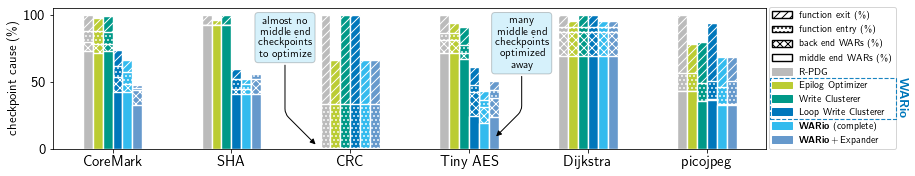

In [15]:
from matplotlib.patches import Patch

ax = plt.figure(figsize=(13,2.7)).add_subplot(111)

cc = [ConfigurationColorMap[c] for c in Configurations[1:]]
labels = [ConfigurationNameMap[c] for c in Configurations[1:]]
width = 0.5
lw = 1.4

def patchwork(ax, hatch):
    for bar in ax.patches:
        if bar.get_hatch() == None: 
            bar.set_hatch(hatch)
            
def plot_bar(N):
    D = dfc[plot[0]]
    for n in range(1, N+1):
        D = D + dfc[plot[n]]
        
    D.T.plot(kind='bar', ax=ax, color=cc, width=width, edgecolor='white', legend=None, linewidth=lw)
    patchwork(ax, hatch_map[plot[N]])

hatch_map = {
    'IR-checkpoints-%': '',
    'Spill-checkpoints-%': 'xxx',
    'Call-checkpoints-%': '...',
    'Pop-checkpoints-%': '///'
}

# Plot the overlapping bars
plot_bar(3)
plot_bar(2)
plot_bar(1)
plot_bar(0)

# Plot the description of the crc benchmark
props = dict(boxstyle='round', facecolor=Color['cyan'], alpha=0.2)
text =  'almost no\nmiddle end\ncheckpoints\nto optimize'
plt.annotate(text, xy=(1.72, 2), xytext=(-32, 130),
        transform=ax.transAxes, textcoords='offset points', fontsize=11,
        horizontalalignment='center', verticalalignment='top',
        bbox=props,
        arrowprops=dict(arrowstyle='-|>', fc='black', connectionstyle='angle,angleA=90,angleB=-45,rad=5'),
)
props = dict(boxstyle='round', facecolor=Color['cyan'], alpha=0.2)
#text =  '\\textbf{many}\n\\textbf{middle end}\n\\textbf{checkpoints}\n\\textbf{optimized}\n\\textbf{away}'
text =  'many\nmiddle end\ncheckpoints\noptimized\naway'
plt.annotate(text, xy=(3.215, 8), xytext=(27, 122),
        transform=ax.transAxes, textcoords='offset points', fontsize=11,
        horizontalalignment='center', verticalalignment='top',
        bbox=props,
        arrowprops=dict(arrowstyle='-|>', fc='black', connectionstyle='angle,angleA=90,angleB=45,rad=5'),
)

plt.xticks(rotation=0)

handles = []
handles.append(Patch(label='middle end WARs (\%)', hatch=hatch_map['IR-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='back end WARs (\%)', hatch=hatch_map['Spill-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='function entry (\%)', hatch=hatch_map['Call-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='function exit (\%)', hatch=hatch_map['Pop-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.reverse()

for idx, l in enumerate(labels):
    handles.append(Patch(label=l, color=cc[idx]))

ax.legend(handles=handles, bbox_to_anchor=(0.018, 1.04, 1.17, 0), loc="upper right", ncol=1, fontsize=9.6)

# Place a box arround the sub-components of the legend
rect = Rectangle( (5.53, 22.3), 1.06, 30.5, linewidth=1.1, linestyle='dashed', fill=None, clip_on=False, zorder=200, color=Color['blue'], alpha=0.9)
plt.gca().add_patch(rect)

# Add some rotated text on the box
plt.gca().text(6.6,24, r'\textbf{WARio}', color=Color['blue'], rotation=-90, fontsize=13, zorder=200)

#plt.xlabel('benchmark')
plt.ylabel(r'checkpoint cause (\%)', fontsize=13)

plt.tight_layout()
plt.show()

In [16]:
# Save the figure
fig = ax.get_figure()
fig.savefig('plots/benchmark-checkpoint-distribution.pdf')

In [17]:
# 
# Create the table for the .elf sizes
#

In [23]:
ColumnNames=[r'\textbf{Ratchet}', r'\textbf{WARio}', r'\textbf{WARio\,+\,\texttt{Expander}}']
avg_ratchet = 0.0
avg_wario = 0.0
avg_wario_exp = 0.0

tex=''
def tex_addl(t):
    global tex
    tex += t + '\n'
    
def tex_add(t):
    global tex
    tex += t

tex_addl(r'% table automatically generated by BenchmarkPlot.ipynb')
tex_addl(r'\begin{tabular}{@{}lrrr@{}}')
tex_addl(r'\toprule')

# One empty cell
# add the names of the configurations
for n in ColumnNames:
    tex_add(' & ' + n)
tex_addl(r' \\ \midrule')

# Add the benchmark columns
for bench in Benchmarks:
    # Get the numbers
    #print(bench)
    uninstr = df[bench].loc['uninstrumented']['ELF-size']
    ratchet = df[bench].loc['opt-ratchet']['ELF-size']
    wario = df[bench].loc['opt-all']['ELF-size']
    wario_exp = df[bench].loc['opt-all-expander']['ELF-size']
      
    ratchet = (ratchet-uninstr)/uninstr*100.0
    wario = (wario-uninstr)/uninstr*100.0
    wario_exp = (wario_exp-uninstr)/uninstr*100.0
    
    avg_ratchet += ratchet
    avg_wario += wario
    avg_wario_exp += wario_exp
    
    ratchet = '{:.1f}'.format(ratchet)
    wario = '{:.1f}'.format(wario)
    wario_exp = '{:.1f}'.format(wario_exp)
    
    tex_add(r'\textsf{'+BenchmarkNameMap[bench]+'}')
    tex_add(' & +'+ratchet+'\%')
    tex_add(' & +'+wario+'\%')
    tex_add(' & +'+wario_exp+'\%')
    tex_addl(r' \\')
    
tex_addl(r' \midrule')

# Add the average
tex_add(r'\emph{average}')

avg_ratchet = avg_ratchet/len(Benchmarks)
avg_wario = avg_wario/len(Benchmarks)
avg_wario_exp = avg_wario_exp/len(Benchmarks)

avg_ratchet = '{:.1f}'.format(avg_ratchet)
avg_wario = '{:.1f}'.format(avg_wario)
avg_wario_exp = '{:.1f}'.format(avg_wario_exp)

tex_add(' & +'+avg_ratchet+'\%')
tex_add(' & +'+avg_wario+'\%')
tex_add(' & +'+avg_wario_exp+'\%')
tex_addl(r' \\ \bottomrule')

# End the table
tex_addl(r'\end{tabular}')
    
print(tex)
# Save the table
with open('plots/elfsize-table.tex', "w") as f:
    # Writing data to a file
    f.write(tex)

% table automatically generated by BenchmarkPlot.ipynb
\begin{tabular}{@{}lrrr@{}}
\toprule
 & \textbf{Ratchet} & \textbf{WARio} & \textbf{WARio\,+\,\texttt{Expander}} \\ \midrule
\textsf{CoreMark} & +39.5\% & +38.7\% & +67.9\% \\
\textsf{SHA} & +33.2\% & +33.5\% & +62.4\% \\
\textsf{CRC} & +8.4\% & +7.8\% & +7.8\% \\
\textsf{Tiny AES} & +16.2\% & +12.2\% & +37.7\% \\
\textsf{Dijkstra} & +7.9\% & +8.3\% & +8.2\% \\
\textsf{picojpeg} & +5.2\% & +12.0\% & +13.4\% \\
 \midrule
\emph{average} & +18.4\% & +18.7\% & +32.9\% \\ \bottomrule
\end{tabular}

